# PyTDMI (TDMI+Python ML/AI)

In [1]:
# Import Libraries for data wrangling and machine learning 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Iterable
import itertools
import seaborn as sns
from sklearn.utils import indexable
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import random
from keras.models import Sequential
from sklearn.utils import shuffle
from keras.layers import Dense
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from graphviz import *
from copy import *
import datetime
from datetime import date, timedelta, datetime
from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import time

#%matplotlib inline 
## Run at end of script
#conn.close()

Using TensorFlow backend.


# Fetch Data from TDMI   

In [2]:
# Import Oracle SQL Libraries
import cx_Oracle
import pandas as pd
import numpy as np

# SQL Connection Parameters
dsn = 'xdm2scan.cpdprd.pt:1521/EDP_PRD_TRD1'
conn = cx_Oracle.connect(user='saTDMIPTP03', password='DmoAcessoBD@0', dsn=dsn)
#print(conn)

# Define a parameter to access the cursor method. This parameter connects to the Oracle instance:
cursor = conn.cursor()

In [3]:
# Load Query file
fd = open('C:/Users/e351722/OneDrive - EDP/SPOT_prediction/Queries/Queries_SPOT.sql', 'r')


sqlFile = fd.read()
fd.close()
sqlCommands = sqlFile.split(';')

In [4]:
# Get SPOT data
query = sqlCommands[0]
# Run Query
start = time.time()
df = pd.read_sql(query, conn)
end = time.time()
print([end - start])

np.shape(df)

[334.9294776916504]


(2731775, 8)

In [5]:
df = df[['DATA','PERIOD_24H_GMT_MORE_1', 'UNIT', 'VALUE']].sort_values(by=['DATA', 'PERIOD_24H_GMT_MORE_1']).reset_index(drop=True)
df = df[df['PERIOD_24H_GMT_MORE_1'] != 'n.a.']
df.PERIOD_24H_GMT_MORE_1 = df.PERIOD_24H_GMT_MORE_1.astype('int')

np.shape(df)

(2622504, 4)

In [6]:
encoder_UNIT = LabelEncoder()
df['encoder_UNIT'] = encoder_UNIT.fit_transform(df['UNIT'],)
df_w_labels = deepcopy(df)


In [7]:
#df = df_w_labels

(array([2.569488e+06, 1.495200e+04, 1.435200e+04, 1.075200e+04,
        4.728000e+03, 2.544000e+03, 1.776000e+03, 1.632000e+03,
        1.224000e+03, 1.056000e+03]),
 array([  -56.87 ,  1128.117,  2313.104,  3498.091,  4683.078,  5868.065,
         7053.052,  8238.039,  9423.026, 10608.013, 11793.   ]),
 <a list of 10 Patch objects>)

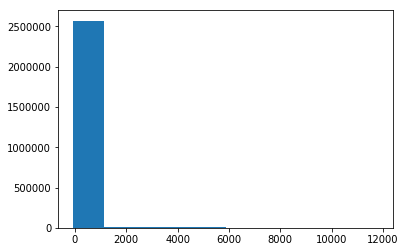

In [8]:
plt.hist(df['VALUE'])

In [9]:
from fbprophet import Prophet
import datetime
df['date'] = pd.DatetimeIndex(df['DATA'])


In [10]:
fbdata = df.reset_index()
#import numpy as np
dateHour = np.empty(len(fbdata), dtype=object)
dateDate = np.empty(len(fbdata), dtype=object)
for i in range(0, len(fbdata)):
    hour = fbdata.PERIOD_24H_GMT_MORE_1[i]
    if hour > 23:
        hour = 23
    dateDate[i] = fbdata.date[i]

    dateHour[i]=datetime.time(hour,0)
    dateDate[i] = dateDate[i].combine(dateDate[i], dateHour[i])
fbdata['date'] = dateDate
fbdata = fbdata.rename(columns={'date':'ds', 'VALUE':'y'})

In [32]:
set(df[df['DATA']< '2008-01-01'].UNIT) & set(df[df['DATA']> '2019-01-01'].UNIT)

{'Precos de Energia Mercado Diario ? Alemanha - EUR/MWh',
 'Precos de Energia Mercado Diario ? Espanha - EUR/MWh',
 'Precos de Energia Mercado Diario ? Franca - EUR/MWh',
 'Precos de Energia Mercado Diario ? Portugal - EUR/MWh',
 'Precos de Energia Mercado Diario Nordpool - EUR/MWh'}

In [33]:
set(df[df['DATA']< '2008-01-01'].encoder_UNIT) & set(df[df['DATA']> '2019-01-01'].encoder_UNIT)

{36, 37, 38, 39, 42}

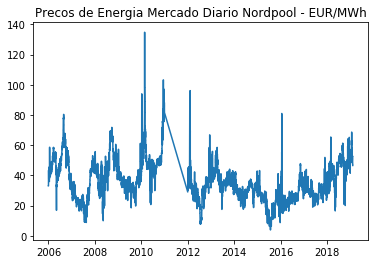

In [49]:
whichunit=42
series = fbdata[fbdata['encoder_UNIT']==whichunit]
plt.title(df[df['encoder_UNIT']==whichunit].UNIT.reset_index(drop=True)[0])
plt.plot(series.ds, series.y)

In [50]:
start = time.time()

# Fit Model
model = Prophet()
model.fit(series)



In [51]:
# Forecast
future = model.make_future_dataframe(periods=131400, freq='H')
forecast = model.predict(future)

end = time.time()
print([end - start])

[1220.4845361709595]


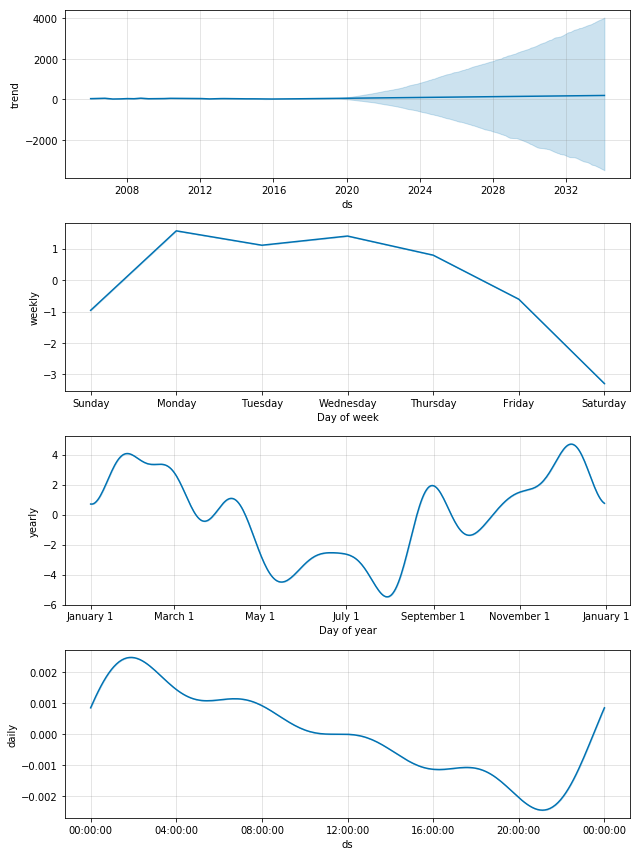

In [52]:
fig = model.plot_components(forecast)

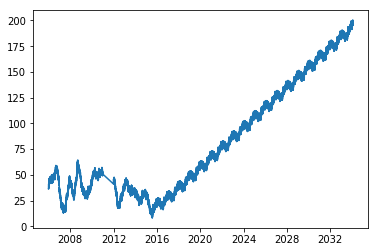

In [53]:
plt.plot(forecast.ds, forecast.yhat)


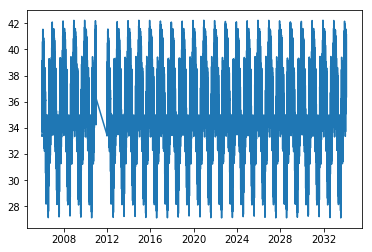

In [54]:
plt.plot(forecast.ds, forecast.weekly+forecast.yearly+forecast.daily+series.y.mean())

In [189]:
from statsmodels.tsa.arima_model import ARIMA
y = series.y
mod = ARIMA(y,order=[24,0,0])


C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [190]:
results = mod.fit()

In [191]:
start_index = len(series)
end_index = len(series)+8760

output = results.predict(start = start_index, end = end_index)


C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


(0, 44472)

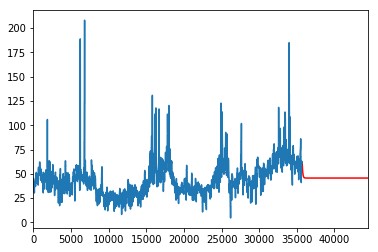

In [193]:
plt.plot(range(start_index, end_index+1), output, c = 'Red')

plt.plot(series.y.reset_index(drop=True))

plt.xlim(0, end_index)

In [39]:
#df = df[df['VALUE_15yr_fut']>-2]
df['date'] = pd.DatetimeIndex(df['DATA'])
df['day'] = df['date'].apply(lambda x: x.day)
df['year'] = df['date'].apply(lambda x: x.year)
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)
df['dayofyear'] = df['date'].apply(lambda x: x.dayofyear)
df['month'] = df['date'].apply(lambda x: x.month)

In [40]:
df = df.fillna(-999)

In [41]:
# Set Dates for Training and Testing splits

pred_date_END = np.max(valid_data.DATA)-timedelta(10) # PRECO_ES_1fut is undefined for the last day, so we test on max(date)-1

pred_date_START =  pred_date_END # - timedelta(6) # number of days for back-testing prediction, 0 means only the last day is used
                                                 # I recommend to use 7 when prototyping, and 0 for production
last_train_date = pred_date_START - timedelta(1) # All the data available minus the last day will be used for training

first_train_date =   np.min(valid_data.DATA) # 395 days of historical data used. More days does not improve prediction.

## Split training,  testing, and prediction data 

train = df[(df.date >= first_train_date) & (df.date <= last_train_date)].drop(['DATA'],1)

#train = train.fillna(method='ffill')
#train = train.fillna(train.mean())

df_test = df
#df_test = df_test.fillna(method='ffill')
#df_test = df_test.fillna(df_test.mean())

test = df_test[(df_test.date >= pred_date_START) & (df_test.date <= pred_date_END)].drop(['DATA'],1)

prediction_set =  df_test[(df_test.date >= pred_date_END+timedelta(1)) & (df_test.date <= pred_date_END+timedelta(1))].drop(['DATA'],1)

X_test, y_test = [test.drop(['date', 'VALUE_15yr_fut', 'UNIT'],1), test['VALUE_15yr_fut']]
X_pred = prediction_set.drop(['date', 'VALUE_15yr_fut', 'UNIT'],1)

X_train, y_train = [train.drop(['date', 'VALUE_15yr_fut', 'UNIT'],1), train['VALUE_15yr_fut']]


In [42]:
X_pred

,PERIOD_24H_GMT_MORE_1,VALUE,encoder_UNIT,day,year,dayofweek,dayofyear,month
65050,0,-1.000000,39,26,2004,0,26,1
65051,0,5262.000000,0,26,2004,0,26,1
65052,0,38.903333,40,26,2004,0,26,1
65053,0,24.975417,37,26,2004,0,26,1
65054,0,38.037750,38,26,2004,0,26,1
65055,0,13.062333,32,26,2004,0,26,1
65056,0,0.000000,33,26,2004,0,26,1
65057,1,-1.000000,39,26,2004,0,26,1
65058,1,38.037750,38,26,2004,0,26,1
65059,1,13.062333,32,26,2004,0,26,1


# Build XGBOOST Model

In [43]:
# Build XGBoost Model
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def prediction_xgboost_pca(x_train, y_train, x_test, y_test):
    """
    Machine learning implementation - XGBoost algorithm.

    :param x_train: Predictors train.
    :param y_train: Response variable train.
    :param x_test: Predictors test.
    :param y_test: Response variable test.
    :return: The XGBoost model.
    """
    # Define the splits.
    # idxs = np.arange(N)
    cv_splits = 5
    clf = xgb.XGBRegressor(objective="reg:linear")
    # Defining the grid search
    
    
    # ---------------------------------------------------without pca-----------------------------------------------------
#{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.03, 'gpu_id': 0, 'learning_rate': 0.1,
 #'max_bin': 256, 'n_estimators': 400,'predictor': 'gpu_predictor', 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.8,
 #'tree_method': 'gpu_hist'}
    # --------------------------------------------------with pca-------------------
#{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.01, 'gpu_id': 0, 'learning_rate': 0.1,
#'max_bin': 256, 'n_estimators': 500, 'predictor': 'gpu_predictor', 'reg_alpha': 0.01,'reg_lambda': 1, 'subsample': 0.8,
#'tree_method': 'gpu_hist'earning_rate': 0.03, 'subsample': 0.8, 'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'max_depth': 15}
    # --------------------------------------------------with pca feat.sel.---------------------------------------------------------
#{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.01, 'gpu_id': 0, 'learning_rate': 0.1,
# 'max_bin': 256, 'n_estimators': 500, 'predictor': 'gpu_predictor', 'reg_alpha': 0.01,'reg_lambda': 1, 'subsample': 0.8, 
# 'tree_method': 'gpu_hist'}
# --------------------------------------------------.---------------------------------------------------------
    
    
  #  , 'gpu_id':[0], 'max_bin':[16],
  #                'predictor': ['gpu_predictor'], 'tree_method': ['gpu_hist'], 'eval_metric': ['mae']
    
    param_grid = {'colsample_bylevel': [1], 'colsample_bytree': [0.7], 'eval_metric': ['mae'],
                  'gamma': [0.03], 'gpu_id': [0], 'learning_rate': [0.1], 'max_bin': [256],
                  'n_estimators': [400], 'predictor': ['gpu_predictor'], 'reg_alpha': [0.01],
                  'reg_lambda': [1], 'subsample': [0.8], 'tree_method': ['gpu_hist']
    
                  }
    
 #   param_grid = {'colsample_bylevel': [1], 'colsample_bytree': [0.7],
 #                 'gamma': [0.03], 'learning_rate': [0.1],
 #                 'n_estimators': [400], 'reg_alpha': [0.01],
 #                 'reg_lambda': [1], 'subsample': [0.8]
 #  
 #                 }

    print('    Model training')

    tree_grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                             iid=False, refit=True, cv=cv_splits, verbose=5, n_jobs = -1) #, scoring='neg_mean_squared_error'
    tree = tree_grid.fit(x_train, y_train)
    

    print(tree.best_params_)
    tree_predict = tree.predict(x_test)
    features = tree.estimator.fit(x_train, y_train).feature_importances_
    feature_imp_df = pd.DataFrame({'Importance': features},
                                  index=x_test.columns.ravel()).sort_values('Importance', ascending=False)

    #feature_imp_plot(imp_feat)
    print(feature_imp_df)
    print('\n', 'r2_score:', r2_score(y_test, tree_predict), '\n',
          'mean_squared_error', mean_squared_error(y_test, tree_predict), '\n',
 #         'mean_absolute_error', mean_absolute_error(y_test, tree_predict), '\n',
          'mean_absolute_percentage_error', mean_absolute_percentage_error(y_test, tree_predict), '\n')
    MAP_error = mean_absolute_percentage_error(y_test, tree_predict)
    
    print('\n')
    
    d7_mean = x_test['VALUE']

    print('\n', 'r2_score d:', r2_score(y_test, d7_mean), '\n',
          'mean_squared_error d', mean_squared_error(y_test, d7_mean), '\n',
 #         'mean_absolute_error d7 mean', mean_absolute_error(d7_mean, tree_predict), '\n',
          'mean_absolute_percentage_error d', mean_absolute_percentage_error(y_test, d7_mean), '\n')

    print('\n')
    metric_model_plot(y_test, tree_predict)
    print('\n')
    model_plot(x_test, y_test, tree_predict)
 
    
    return tree_predict, y_test, tree, MAP_error


def model_plot(x, y, tree_predict):

    plt.figure()
    plt.scatter( y, x['VALUE'], c="cornflowerblue", label="d")
    plt.scatter( y, tree_predict, color="darkorange", label="XGBoost", linewidth=2)
    plt.xlabel("Actual D+1 Price")
    plt.ylabel("Predicted D+1 Price")
    plt.title("Decision Tree Regression")
    plt.legend()
    plt.show()
    return None


def metric_model_plot(y_test, tree_predict):
    max_x = max(y_test)
    min_x = min(y_test)
    max_y = max(tree_predict)
    min_y = min(tree_predict)
    plt.figure()
    plt.scatter(y_test, tree_predict, c="darkorange", label="test data")
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.plot([min_x, max_x], [min_x, max_x], 'k--')

    plt.xlabel("Actual D+1 Price")
    plt.ylabel("Predicted D+1 Price")
    plt.title("Decision Tree")
    plt.legend()
    #plt.savefig('fig.png')  # save the figure to file
    plt.show()
    
    plt.figure()
    plt.plot(y_test, c = 'black', label = 'Actual')
    plt.plot(tree_predict, c = 'darkorange', label = 'Predicted')
    plt.xlabel("Predicted vs. Actual Price")
    plt.ylabel("Price")
    plt.title("Hour")
    plt.legend()
    plt.show()
    return None



    Model training
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.4s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.9s finished


{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.03, 'gpu_id': 0, 'learning_rate': 0.1, 'max_bin': 256, 'n_estimators': 400, 'predictor': 'gpu_predictor', 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
                       Importance
dayofyear                0.347826
encoder_UNIT             0.301242
VALUE                    0.187888
dayofweek                0.066770
year                     0.062112
day                      0.034161
PERIOD_24H_GMT_MORE_1    0.000000
month                    0.000000

 r2_score: 0.9999764027820166 
 mean_squared_error 5.931512850831029 
 mean_absolute_percentage_error 0.838310335672373 




 r2_score d: -1.7842661325739537 
 mean_squared_error d 699866.8384184444 
 mean_absolute_percentage_error d 96.80264263421434 





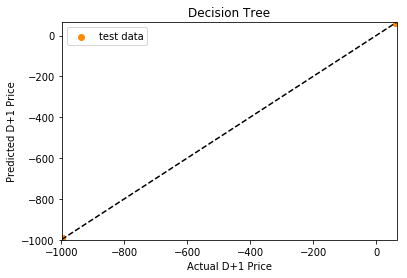

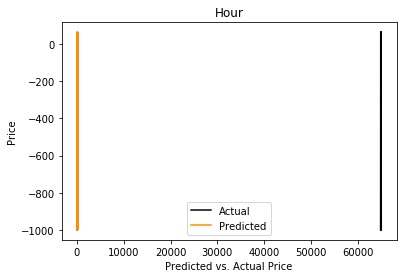

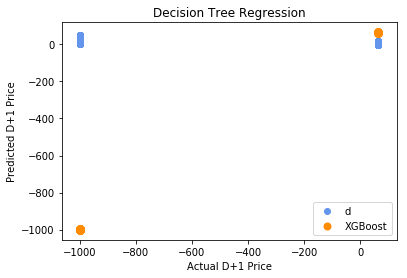

In [44]:
from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
predicted1, y_test1, tree1, MAP_error1 = prediction_xgboost_pca(X_train, y_train, X_test, y_test)

# Generate Day-ahead prediction
tree1_prediction = list(tree1.predict(X_pred))

In [49]:
df

,DATA,PERIOD_24H_GMT_MORE_1,UNIT,VALUE,encoder_UNIT,VALUE_15yr_fut,date,day,year,dayofweek,dayofyear,month
0,2003-01-01,0,Precos de Energia Mercado Diario ? Franca - EU...,13.586583,38,-999.000000,2003-01-01,1,2003,2,1,1
1,2003-01-01,0,Precos de Energia Mercado Diario ? Espanha - E...,15.400417,37,46.819583,2003-01-01,1,2003,2,1,1
2,2003-01-01,0,Preco de interconex?o ES->FR (Calculado) - EUR...,0.852792,32,-999.000000,2003-01-01,1,2003,2,1,1
3,2003-01-01,0,Precos de Energia Mercado Diario ? Portugal - ...,-1.000000,39,46.819583,2003-01-01,1,2003,2,1,1
4,2003-01-01,0,Preco de interconex?o FR->ES (Calculado) - EUR...,2.666625,33,-999.000000,2003-01-01,1,2003,2,1,1
5,2003-01-01,0,Precos de Energia Mercado Diario APX para HUB ...,39.826667,40,-999.000000,2003-01-01,1,2003,2,1,1
6,2003-01-01,1,Precos de Energia Mercado Diario APX para HUB ...,39.826667,40,-999.000000,2003-01-01,1,2003,2,1,1
7,2003-01-01,1,Precos de Energia Mercado Diario ? Franca - EU...,13.586583,38,-999.000000,2003-01-01,1,2003,2,1,1
8,2003-01-01,1,Preco de interconex?o ES->FR (Calculado) - EUR...,0.852792,32,-999.000000,2003-01-01,1,2003,2,1,1
9,2003-01-01,1,Precos de Energia Mercado Diario ? Espanha - E...,15.400417,37,46.819583,2003-01-01,1,2003,2,1,1


In [111]:
## Feature Engineering
## First let's create day averages for the target variable PRECO_ES
#daydata2=df1.groupby(['DATA']).PRECO_ES.mean()
#daydata2.name = 'DAY_MEAN_ES'
#df_daily2 = pd.DataFrame(daydata2)
#df1 = pd.merge(df1, df_daily2, how='left', on = ['DATA'])

lag = [5475]
df_new = deepcopy(df)
df_new = df_new.drop(['DATA', 'PERIOD_24H_GMT_MORE_1', 'UNIT'], axis=1)

for col in df_new.columns:
    for l in lag:
        df_new.loc[:,str(col)+'_'+str(l)] = df_new[col].shift(l)
        ## Rolling averages do not seem to improve the prediction, so I usually commented them out (next 2 lines)
        #datas=df_new[col].rolling(min_periods=1,window=7).mean()
        #df_new.loc[:,str(col)+'_mean_'+str(l)] = datas.reset_index(level=0, drop=True)
        
df_new = pd.concat([df[['DATA','HORA']], df_new], axis = 1)
df = df_new

df = pd.merge(df, df7, how='left', on = ['DATA', 'HORA'])


# Eliminate NA's from Target Variable
df['PRECO_ES'] = df.PRECO_ES.fillna(0).replace(np.inf, 0)
# Create Y(t+1), the variable we want to predict
df['PRECO_ES_1fut']=df.groupby([ 'HORA'])['PRECO_ES'].shift(-1)
# Create X(t+1), for variables we have future values of
df['Wind_ES_1fut']=df.groupby([ 'HORA'])['Wind_ES'].shift(-1)
df['REE_DEMAND_ES_1fut']=df.groupby([ 'HORA'])['REE_DEMAND_ES'].shift(-1)
df['PRECO_FR_1fut']=df.groupby([ 'HORA'])['PRECO_FR'].shift(-1)
df['Solar_ES_1fut']=df.groupby([ 'HORA'])['Solar_ES'].shift(-1)
df['METEO_DEMAND_PT_1fut']=df.groupby([ 'HORA'])['METEO_DEMAND_PT'].shift(-1)


df_w_labels = deepcopy(df)
df_copy = deepcopy(df)
df_copy_labels = deepcopy(df)

df['date'] = pd.DatetimeIndex(df['DATA'])
df['day'] = df['date'].apply(lambda x: x.day)
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)
#df['dayofyear'] = df['date'].apply(lambda x: x.dayofyear)
#df['month'] = df['date'].apply(lambda x: x.month)
#df['year'] = df['date'].apply(lambda x: x.year)

# drop low correlated lag variable
#df = df.drop(['PRECO_PT_365'],1)
df_new = df.drop(columns=['DATA', 'date'], axis=1) 
a=np.abs(df_new.corr().PRECO_ES_1fut)<.1
dropvariables = df.fillna(df.mean()).corr()[a==True].index[:-1]
df=df.drop(df[dropvariables[:-1]],axis=1)

# Set Dates for Training and Testing splits

pred_date_END = np.max(df1.DATA)-timedelta(1) # PRECO_ES_1fut is undefined for the last day, so we test on max(date)-1

pred_date_START =  pred_date_END # - timedelta(6) # number of days for back-testing prediction, 0 means only the last day is used
                                                 # I recommend to use 7 when prototyping, and 0 for production
last_train_date = pred_date_START - timedelta(1) # All the data available minus the last day will be used for training

first_train_date =   pred_date_END - timedelta(395) # 395 days of historical data used. More days does not improve prediction.

## Split training,  testing, and prediction data 

train = df[(df.date >= first_train_date) & (df.date <= last_train_date)].drop(['DATA'],1)

train = train.fillna(method='ffill')
train = train.fillna(train.mean())

df_test = df
df_test = df_test.fillna(method='ffill')
df_test = df_test.fillna(df_test.mean())

test = df_test[(df_test.date >= pred_date_START) & (df_test.date <= pred_date_END)].drop(['DATA'],1)

prediction_set =  df_test[(df_test.date >= pred_date_END+timedelta(1)) & (df_test.date <= pred_date_END+timedelta(1))].drop(['DATA'],1)

X_test, y_test = [test.drop(['date', 'PRECO_ES_1fut'],1), test['PRECO_ES_1fut']]
X_pred = prediction_set.drop(['date', 'PRECO_ES_1fut'],1)

X_train, y_train = [train.drop(['date', 'PRECO_ES_1fut'],1), train['PRECO_ES_1fut']]

# Apply PCA to Data and Split Training, Testing, and Forecasting (pred) sets
train = df[(df.date >= first_train_date) & (df.date <= last_train_date)].drop(['DATA'],1)

train = train.fillna(method='ffill')
train = train.fillna(train.mean())
train = train.fillna(0)

from sklearn.decomposition import PCA
pca = PCA(0.95)  # keep components that explain 95% of the variance
datas = train.drop(['date','PRECO_ES_1fut'],1)
data_pca = pca.fit(datas)
PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  
#train = train.reset_index(drop=True)
#list(train)

df_test = df
df_test = df_test.fillna(method='ffill')
df_test = df_test.fillna(df_test.mean())
df_test = df_test.fillna(0)

test = df_test[(df_test.date >= pred_date_START) & (df_test.date <= pred_date_END)].drop(['DATA'],1)

test_pca = data_pca.transform(test.drop(['date','PRECO_ES_1fut'],1))

prediction_set =  df_test[(df_test.date >= pred_date_END+timedelta(1)) & (df_test.date <= pred_date_END+timedelta(1))].drop(['DATA'],1)

prediction_pca = data_pca.transform(prediction_set.drop(['date', 'PRECO_ES_1fut'],1))

train_pca = data_pca.transform(train.drop(['date','PRECO_ES_1fut'],1))


train = pd.concat([train.reset_index(), pd.DataFrame(train_pca)], axis=1)
test = pd.concat([test.reset_index(), pd.DataFrame(test_pca)], axis=1)
prediction_set = pd.concat([prediction_set.reset_index(), pd.DataFrame(prediction_pca)], axis=1)


train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
prediction_set=prediction_set.reset_index(drop=True)

train = train.drop(['index'],1)
test = test.drop(['index'],1)
prediction_set=prediction_set.drop(['index'],1)

X_test, y_test = [test.drop(['date', 'PRECO_ES_1fut'],1), test['PRECO_ES_1fut']]
X_pred = prediction_set.drop(['date', 'PRECO_ES_1fut'],1)

X_train, y_train = [train.drop(['date', 'PRECO_ES_1fut'],1), train['PRECO_ES_1fut']]

X_test.head()

,DATA,PERIOD_24H_GMT_MORE_1,UNIT,VALUE,encoder_UNIT
0,2003-01-01,00,Precos de Energia Mercado Diario ? Franca - EU...,13.586583,38
1,2003-01-01,00,Precos de Energia Mercado Diario ? Espanha - E...,15.400417,37
2,2003-01-01,00,Preco de interconex?o ES->FR (Calculado) - EUR...,0.852792,32
3,2003-01-01,00,Precos de Energia Mercado Diario ? Portugal - ...,-1.000000,39
4,2003-01-01,00,Preco de interconex?o FR->ES (Calculado) - EUR...,2.666625,33
5,2003-01-01,00,Precos de Energia Mercado Diario APX para HUB ...,39.826667,40
6,2003-01-01,01,Precos de Energia Mercado Diario APX para HUB ...,39.826667,40
7,2003-01-01,01,Precos de Energia Mercado Diario ? Franca - EU...,13.586583,38
8,2003-01-01,01,Preco de interconex?o ES->FR (Calculado) - EUR...,0.852792,32
9,2003-01-01,01,Precos de Energia Mercado Diario ? Espanha - E...,15.400417,37


In [100]:
# Format dataframe
newdf = pd.pivot_table(df, index=['DATA'], columns = 'UNIT')
newdf = newdf.reset_index()
dfmerged = pd.merge(df[['DATA','PERIOD_24H_GMT_MORE_1']], newdf, how='left', on = ['DATA'])
df_onehot = dfmerged.reset_index(drop=True)
df_onehot.head()

C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,DATA,PERIOD_24H_GMT_MORE_1,"(VALUE, Baltic DRY Index - n.a.)","(VALUE, ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Austria - Luxemburgo) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Luxemburgo) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Austria (Alemanha - Austria - Luxemburgo) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Austria (Austria) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Belgica (Belgica) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-1) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-2) - EUR/MWH)",...,"(VALUE, Precos de Energia Mercado Diario Nordpool N2EX - GBP/MWh)","(VALUE, Precos de Energia Mercado Diario Polpex - EUR/MWh)","(VALUE, Precos de Energia Mercado Diario Polpex - PLN/MWh)","(VALUE, Precos de electricidade Mercado Diario - IT - Reuters - EUR/MWh)","(VALUE, Precos de electricidade Mercado Diario - UK - Reuters - GBP/MWh)","(VALUE, Precos de electricidade Mercado Diario ? Franca (EPEX) - Reuters - EUR/MWh)","(VALUE, Precos de electricidade Mercado Diario APX para HUB NL - Reuters - EUR/MWh)","(VALUE, Precos de electricidade Mercado Diario Belpex - Reuters - EUR/MWh)","(VALUE, Precos de electricidade Mercado Diario Polpex - Reuters - PLN/MWh)","(VALUE, Precos de eletricidade Mercado Diario ? Alemanha (EEX Phelix) - Reuters - EUR/MWh)"
0,2003-01-01,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-01-01,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-01-01,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-01-01,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-01-01,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
df_onehot

,DATA,PERIOD_24H_GMT_MORE_1,"(VALUE, Baltic DRY Index - n.a.)","(VALUE, ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Austria - Luxemburgo) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Alemanha (Alemanha - Luxemburgo) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Austria (Alemanha - Austria - Luxemburgo) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Austria (Austria) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Belgica (Belgica) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-1) - EUR/MWH)","(VALUE, ENTSOE: Day Ahead Prices - Dinamarca (Dinamarca-2) - EUR/MWH)",...,"(VALUE, Precos de Energia Mercado Diario Nordpool N2EX - GBP/MWh)","(VALUE, Precos de Energia Mercado Diario Polpex - EUR/MWh)","(VALUE, Precos de Energia Mercado Diario Polpex - PLN/MWh)","(VALUE, Precos de electricidade Mercado Diario - IT - Reuters - EUR/MWh)","(VALUE, Precos de electricidade Mercado Diario - UK - Reuters - GBP/MWh)","(VALUE, Precos de electricidade Mercado Diario ? Franca (EPEX) - Reuters - EUR/MWh)","(VALUE, Precos de electricidade Mercado Diario APX para HUB NL - Reuters - EUR/MWh)","(VALUE, Precos de electricidade Mercado Diario Belpex - Reuters - EUR/MWh)","(VALUE, Precos de electricidade Mercado Diario Polpex - Reuters - PLN/MWh)","(VALUE, Precos de eletricidade Mercado Diario ? Alemanha (EEX Phelix) - Reuters - EUR/MWh)"
0,2003-01-01,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-01-01,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-01-01,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-01-01,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-01-01,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2003-01-01,00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2003-01-01,01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2003-01-01,01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2003-01-01,01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2003-01-01,01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
df

,DATA,PERIOD_24H_GMT_MORE_1,UNIT,VALUE
0,2003-01-01,00,Precos de Energia Mercado Diario ? Franca - EU...,13.586583
1,2003-01-01,00,Precos de Energia Mercado Diario ? Espanha - E...,15.400417
2,2003-01-01,00,Preco de interconex?o ES->FR (Calculado) - EUR...,0.852792
3,2003-01-01,00,Precos de Energia Mercado Diario ? Portugal - ...,-1.000000
4,2003-01-01,00,Preco de interconex?o FR->ES (Calculado) - EUR...,2.666625
5,2003-01-01,00,Precos de Energia Mercado Diario APX para HUB ...,39.826667
6,2003-01-01,01,Precos de Energia Mercado Diario APX para HUB ...,39.826667
7,2003-01-01,01,Precos de Energia Mercado Diario ? Franca - EU...,13.586583
8,2003-01-01,01,Preco de interconex?o ES->FR (Calculado) - EUR...,0.852792
9,2003-01-01,01,Precos de Energia Mercado Diario ? Espanha - E...,15.400417


# Pre-process Data

In [15]:
# Join Data Frames. Left join on df2 because it has future data that df1 does not.
df = pd.merge(df2, df1, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df3, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df4, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df5, how='left', on = ['DATA', 'HORA'])
df = pd.merge(df, df6, how='left', on = ['DATA', 'HORA'])


# Feature Engineering
# First let's create day averages for the target variable PRECO_ES
daydata2=df1.groupby(['DATA']).PRECO_ES.mean()
daydata2.name = 'DAY_MEAN_ES'
df_daily2 = pd.DataFrame(daydata2)
df1 = pd.merge(df1, df_daily2, how='left', on = ['DATA'])

lag = [7]
df_new = deepcopy(df)
df_new = df_new.drop(['DATA', 'HORA'], axis=1)

for col in df_new.columns:
    for l in lag:
        df_new.loc[:,str(col)+'_'+str(l)] = df_new[col].shift(l)
        ## Rolling averages do not seem to improve the prediction, so I usually commented them out (next 2 lines)
        #datas=df_new[col].rolling(min_periods=1,window=7).mean()
        #df_new.loc[:,str(col)+'_mean_'+str(l)] = datas.reset_index(level=0, drop=True)
        
df_new = pd.concat([df[['DATA','HORA']], df_new], axis = 1)
df = df_new

df = pd.merge(df, df7, how='left', on = ['DATA', 'HORA'])


# Eliminate NA's from Target Variable
df['PRECO_ES'] = df.PRECO_ES.fillna(0).replace(np.inf, 0)
# Create Y(t+1), the variable we want to predict
df['PRECO_ES_1fut']=df.groupby([ 'HORA'])['PRECO_ES'].shift(-1)
# Create X(t+1), for variables we have future values of
df['Wind_ES_1fut']=df.groupby([ 'HORA'])['Wind_ES'].shift(-1)
df['REE_DEMAND_ES_1fut']=df.groupby([ 'HORA'])['REE_DEMAND_ES'].shift(-1)
df['PRECO_FR_1fut']=df.groupby([ 'HORA'])['PRECO_FR'].shift(-1)
df['Solar_ES_1fut']=df.groupby([ 'HORA'])['Solar_ES'].shift(-1)
df['METEO_DEMAND_PT_1fut']=df.groupby([ 'HORA'])['METEO_DEMAND_PT'].shift(-1)


df_w_labels = deepcopy(df)
df_copy = deepcopy(df)
df_copy_labels = deepcopy(df)

df['date'] = pd.DatetimeIndex(df['DATA'])
df['day'] = df['date'].apply(lambda x: x.day)
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)
#df['dayofyear'] = df['date'].apply(lambda x: x.dayofyear)
#df['month'] = df['date'].apply(lambda x: x.month)
#df['year'] = df['date'].apply(lambda x: x.year)

# drop low correlated lag variable
#df = df.drop(['PRECO_PT_365'],1)
df_new = df.drop(columns=['DATA', 'date'], axis=1) 
a=np.abs(df_new.corr().PRECO_ES_1fut)<.1
dropvariables = df.fillna(df.mean()).corr()[a==True].index[:-1]
df=df.drop(df[dropvariables[:-1]],axis=1)

# Set Dates for Training and Testing splits

pred_date_END = np.max(df1.DATA)-timedelta(1) # PRECO_ES_1fut is undefined for the last day, so we test on max(date)-1

pred_date_START =  pred_date_END # - timedelta(6) # number of days for back-testing prediction, 0 means only the last day is used
                                                 # I recommend to use 7 when prototyping, and 0 for production
last_train_date = pred_date_START - timedelta(1) # All the data available minus the last day will be used for training

first_train_date =   pred_date_END - timedelta(395) # 395 days of historical data used. More days does not improve prediction.

## Split training,  testing, and prediction data 

train = df[(df.date >= first_train_date) & (df.date <= last_train_date)].drop(['DATA'],1)

train = train.fillna(method='ffill')
train = train.fillna(train.mean())

df_test = df
df_test = df_test.fillna(method='ffill')
df_test = df_test.fillna(df_test.mean())

test = df_test[(df_test.date >= pred_date_START) & (df_test.date <= pred_date_END)].drop(['DATA'],1)

prediction_set =  df_test[(df_test.date >= pred_date_END+timedelta(1)) & (df_test.date <= pred_date_END+timedelta(1))].drop(['DATA'],1)

X_test, y_test = [test.drop(['date', 'PRECO_ES_1fut'],1), test['PRECO_ES_1fut']]
X_pred = prediction_set.drop(['date', 'PRECO_ES_1fut'],1)

X_train, y_train = [train.drop(['date', 'PRECO_ES_1fut'],1), train['PRECO_ES_1fut']]

# Apply PCA to Data and Split Training, Testing, and Forecasting (pred) sets
train = df[(df.date >= first_train_date) & (df.date <= last_train_date)].drop(['DATA'],1)

train = train.fillna(method='ffill')
train = train.fillna(train.mean())
train = train.fillna(0)

from sklearn.decomposition import PCA
pca = PCA(0.95)  # keep components that explain 95% of the variance
datas = train.drop(['date','PRECO_ES_1fut'],1)
data_pca = pca.fit(datas)
PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  
#train = train.reset_index(drop=True)
#list(train)

df_test = df
df_test = df_test.fillna(method='ffill')
df_test = df_test.fillna(df_test.mean())
df_test = df_test.fillna(0)

test = df_test[(df_test.date >= pred_date_START) & (df_test.date <= pred_date_END)].drop(['DATA'],1)

test_pca = data_pca.transform(test.drop(['date','PRECO_ES_1fut'],1))

prediction_set =  df_test[(df_test.date >= pred_date_END+timedelta(1)) & (df_test.date <= pred_date_END+timedelta(1))].drop(['DATA'],1)

prediction_pca = data_pca.transform(prediction_set.drop(['date', 'PRECO_ES_1fut'],1))

train_pca = data_pca.transform(train.drop(['date','PRECO_ES_1fut'],1))


train = pd.concat([train.reset_index(), pd.DataFrame(train_pca)], axis=1)
test = pd.concat([test.reset_index(), pd.DataFrame(test_pca)], axis=1)
prediction_set = pd.concat([prediction_set.reset_index(), pd.DataFrame(prediction_pca)], axis=1)


train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
prediction_set=prediction_set.reset_index(drop=True)

train = train.drop(['index'],1)
test = test.drop(['index'],1)
prediction_set=prediction_set.drop(['index'],1)

X_test, y_test = [test.drop(['date', 'PRECO_ES_1fut'],1), test['PRECO_ES_1fut']]
X_pred = prediction_set.drop(['date', 'PRECO_ES_1fut'],1)

X_train, y_train = [train.drop(['date', 'PRECO_ES_1fut'],1), train['PRECO_ES_1fut']]

X_test.head()

[0.46077158 0.27742426 0.13658122 0.05408737 0.03661624]


,HORA,Wind_ES,PRECO_ES,PRECO_PT,ENERGIA,REE_DEMAND_ES,PRECO_FR,Solar_ES,METEO_DEMAND_PT,Wind_ES_7,...,PRECO_FR_1fut,Solar_ES_1fut,METEO_DEMAND_PT_1fut,day,dayofweek,0,1,2,3,4
0,1,12044.388,55.00,66.55,25723.10,28266.0,57.6,0.0,96.636439,14775.844,...,55.0,0.0,120.522005,29,1,1790.051688,12007.101208,1903.185082,914.811669,827.645472
1,2,11701.439,50.15,65.87,23609.40,26407.0,55.8,0.0,78.741059,14158.060,...,54.4,0.0,142.683547,29,1,-1636.186417,12564.786237,835.693300,965.002264,783.116437
2,3,11420.948,49.89,65.10,22787.50,25095.0,54.0,0.0,75.013343,13880.676,...,52.5,0.0,154.285631,29,1,-3390.483855,13364.783855,-881.911678,747.921425,969.158381
3,4,11193.185,47.43,53.95,22742.80,24673.0,50.9,0.0,72.945569,13792.663,...,49.4,0.0,159.896212,29,1,-4118.604151,12763.609033,-303.196124,482.564770,648.494853
4,5,11203.254,45.97,52.33,22892.25,24664.0,51.1,0.0,71.375157,13518.356,...,49.0,0.0,162.211295,29,1,-4284.705264,11898.479285,567.352886,311.063553,393.034907


# Build XGBOOST Model

In [17]:
import xgboost as xgb

def prediction_xgboost_gpu_optimise(x_train, y_train, x_test, y_test):
    """
    Machine learning implementation - XGBoost algorithm.

    :param x_train: Predictors train.
    :param y_train: Response variable train.
    :param x_test: Predictors test.
    :param y_test: Response variable test.
    :return: The XGBoost model.
    """
    # Define the splits.
    # idxs = np.arange(N)
    cv_splits = 5
    clf = xgb.XGBRegressor(objective='reg:linear')
    # Defining the grid search
    # ---------------------------------------------------for 6 days-----------------------------------------------------
    # {'max_depth': 5, 'reg_alpha': 0, 'n_estimators': 4000, 'colsample_bytree': 0.8, 'seed': 123, 'subsample': 0.8,
    #  'reg_lambda': 70, 'min_child_weight': 1, 'gamma': 0.05, 'colsample_bylevel': 1, 'nthread': -1}
    # ------------------------------------------------------------------------------------------------------------------
    # --------------------------------------------------for 20 days-----------------------------------------------------
    # {'max_depth': 7, 'gamma': 0.002, 'nthread': -1, 'subsample': 0.5, 'reg_alpha': 0, 'n_estimators': 1000,
    #  'seed': 123, 'colsample_bytree': 1, 'reg_lambda': 100, 'colsample_bylevel': 1, 'min_child_weight': 1}
    # ------------------------------------------------------------------------------------------------------------------
    # --------------------------------------------------subsample and colsample_bytree optimal params-------------------
    # {'gamma': 0.03, 'n_estimators': 1000, 'reg_alpha': 0, 'max_depth': 9, 'colsample_bytree': 0.7, 'seed': 123, 'subsample': 0.8,
    #'learning_rate': 0.03, 'colsample_bylevel': 1, 'reg_lambda': 1, 'min_child_weight': 3}
    # ------------------------------------------------------------------------------------------------------------------
    # --------------------------------------------------reg_alpha optimal params-------------------
    #{'seed': 123, 'reg_alpha': 0.01, 'min_child_weight': 3, 'reg_lambda': 1, 'n_estimators': 1000, 'gamma': 0.03, 
    #'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'max_depth': 15}
    # ------------------------------------------------------------------------------------------------------------------

    n_estimators = [400]
    learning_rate = [0.1]
    gamma = [0.03]
    max_bin = [16, 64, 256]
    subsample = [0.8]
    
    param_grid = {
                  'subsample': subsample, 'gamma': gamma, 'learning_rate': learning_rate, 'n_estimators': n_estimators, 'colsample_bytree': [0.7],
                  'reg_lambda': [1], 'reg_alpha': [0.01], 'colsample_bylevel': [1], 'gpu_id':[0], 'max_bin':max_bin,
                  'predictor': ['gpu_predictor'], 'tree_method': ['gpu_hist'], 'eval_metric': ['mae']
                  }
    
    print('    Model training')

    tree_grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                             iid=False, refit=True, cv=cv_splits, verbose=5, n_jobs = -1)
    tree = tree_grid.fit(x_train, y_train)
    

    print(tree.best_params_)
    tree_predict = tree.predict(x_test)
    features = tree.estimator.fit(x_train, y_train).feature_importances_
    feature_imp_df = pd.DataFrame({'Importance': features},
                                  index=x_test.columns.ravel()).sort_values('Importance', ascending=False)

    #feature_imp_plot(imp_feat)
    print(feature_imp_df)
    print('\n', 'r2_score:', r2_score(y_test, tree_predict), '\n',
          'mean_squared_error', mean_squared_error(y_test, tree_predict), '\n',
 #         'mean_absolute_error', mean_absolute_error(y_test, tree_predict), '\n',
          'mean_absolute_percentage_error', mean_absolute_percentage_error(y_test, tree_predict), '\n')
    MAP_error = mean_absolute_percentage_error(y_test, tree_predict)
        

    print('\n')
    #metric_model_plot(y_test, tree_predict)
 
    print('\n')
 
    
    return tree_predict, y_test, tree, MAP_error

def metric_model_plot(y_test, tree_predict):

    plt.figure()
    plt.scatter(y_test, tree_predict, c="darkorange", label="test data")
    max_x = max(y_test)
    min_x = min(y_test)
    max_y = max(tree_predict)
    min_y = min(tree_predict)
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.plot([min_x, max_x], [min_x, max_x], 'k--')

    plt.xlabel("Actual D+1 Price")
    plt.ylabel("Predicted D+1 Price")
    plt.title("Decision Tree")
    plt.legend()
    #plt.savefig('fig.png')  # save the figure to file
    plt.show()
    return None


# Train XGB Model and Generate Back-Tested Prediction

In [18]:
from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
predicted1, y_test1, tree1, MAP_error1 = prediction_xgboost_gpu_optimise(X_train, y_train, X_test, y_test)

# Generate Day-ahead prediction
tree1_prediction = list(tree1.predict(X_pred))

    Model training
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   34.9s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   44.3s finished


{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.03, 'gpu_id': 0, 'learning_rate': 0.1, 'max_bin': 256, 'n_estimators': 400, 'predictor': 'gpu_predictor', 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
                                                    Importance
REE_DEMAND_ES_1fut                                    0.106628
Wind_ES_1fut                                          0.085014
(VALUE, ENTSOE: Day Ahead Prices - Espanha (Esp...    0.082133
PRECO_FR_1fut                                         0.077810
HORA                                                  0.054755
3                                                     0.051873
4                                                     0.051873
PRECO_ES                                              0.040346
(VALUE, ENTSOE: Day Ahead Prices - Portugal (Po...    0.025937
Wind_ES                                               0.025937
ENERGIA_7                            

In [19]:
from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
predicted2, y_test2, tree2, MAP_error2 = prediction_xgboost_pca(X_train, y_train, X_test, y_test)

# Generate Day-ahead prediction
tree2_prediction = list(tree2.predict(X_pred))

    Model training
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.1s remaining:   19.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished


{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.03, 'gpu_id': 0, 'learning_rate': 0.1, 'max_bin': 256, 'n_estimators': 400, 'predictor': 'gpu_predictor', 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
                                                    Importance
REE_DEMAND_ES_1fut                                    0.106628
Wind_ES_1fut                                          0.085014
(VALUE, ENTSOE: Day Ahead Prices - Espanha (Esp...    0.082133
PRECO_FR_1fut                                         0.077810
HORA                                                  0.054755
3                                                     0.051873
4                                                     0.051873
PRECO_ES                                              0.040346
(VALUE, ENTSOE: Day Ahead Prices - Portugal (Po...    0.025937
Wind_ES                                               0.025937
ENERGIA_7                            

In [20]:
# Run XGBoost without PCA to select top features only
train = df[(df.date >= first_train_date) & (df.date <= last_train_date)].drop(['DATA'],1)


train = train.fillna(method='ffill')
train = train.fillna(train.mean())


df_test = df
df_test = df_test.fillna(method='ffill')
df_test = df_test.fillna(df_test.mean())

test = df_test[(df_test.date >= pred_date_START) & (df_test.date <= pred_date_END)].drop(['DATA'],1)

prediction_set =  df_test[(df_test.date >= pred_date_END+timedelta(1)) & (df_test.date <= pred_date_END+timedelta(1))].drop(['DATA'],1)


train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
prediction_set=prediction_set.reset_index(drop=True)



X_test, y_test = [test.drop(['date', 'PRECO_ES_1fut'],1), test['PRECO_ES_1fut']]
X_pred = prediction_set.drop(['date', 'PRECO_ES_1fut'],1)

X_train, y_train = [train.drop(['date', 'PRECO_ES_1fut'],1), train['PRECO_ES_1fut']]

from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
predicted3, y_test3, tree3, MAP_error3 = prediction_xgboost_gpu_optimise(X_train, y_train, X_test, y_test)


tree3_prediction = list(tree3.predict(X_pred))
#plt.plot(tree3_prediction)

    Model training
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   31.8s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   41.0s finished


{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.03, 'gpu_id': 0, 'learning_rate': 0.1, 'max_bin': 256, 'n_estimators': 400, 'predictor': 'gpu_predictor', 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
                                                    Importance
Wind_ES_1fut                                          0.154179
REE_DEMAND_ES_1fut                                    0.139769
(VALUE, ENTSOE: Day Ahead Prices - Espanha (Esp...    0.087896
PRECO_FR_1fut                                         0.080692
HORA                                                  0.059078
Wind_ES                                               0.048991
PRECO_ES                                              0.033141
Solar_ES_1fut                                         0.030259
dayofweek                                             0.024496
(VALUE, ENTSOE: Day Ahead Prices - Portugal (Po...    0.021614
Solar_ES                             

# Drop Least important features 
# Perform Principal component Analysis
# Normalize Data for Neural Networks

In [21]:
features = tree3.estimator.fit(X_train, y_train).feature_importances_
feature_imp_df = pd.DataFrame({'Importance': features},
                                  index=X_test.columns.ravel()).sort_values('Importance', ascending=False)
a = feature_imp_df<= 0.01
b = a[a.Importance==True]
dropvariables = b.index
df=df.drop(df[dropvariables],axis=1)

train = df[(df.date >= first_train_date) & (df.date <= last_train_date)].drop(['DATA'],1)

train = train.fillna(method='ffill')
train = train.fillna(train.mean())

df_test = df
df_test = df_test.fillna(method='ffill')
df_test = df_test.fillna(df_test.mean())

test = df_test[(df_test.date >= pred_date_START) & (df_test.date <= pred_date_END)].drop(['DATA'],1)

prediction_set =  df_test[(df_test.date >= pred_date_END+timedelta(1)) & (df_test.date <= pred_date_END+timedelta(1))].drop(['DATA'],1)

train = pd.concat([train.reset_index(), pd.DataFrame(train_pca)], axis=1)
test = pd.concat([test.reset_index(), pd.DataFrame(test_pca)], axis=1)
prediction_set = pd.concat([prediction_set.reset_index(), pd.DataFrame(prediction_pca)], axis=1)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
prediction_set=prediction_set.reset_index(drop=True)

train = train.drop(['index'],1)
test = test.drop(['index'],1)
prediction_set=prediction_set.drop(['index'],1)

X_test, y_test = [test.drop(['date', 'PRECO_ES_1fut'],1), test['PRECO_ES_1fut']]
X_pred = prediction_set.drop(['date', 'PRECO_ES_1fut'],1)

X_train, y_train = [train.drop(['date', 'PRECO_ES_1fut'],1), train['PRECO_ES_1fut']]

# Normalze variables, Final Preprocessing Step, needed for Neural Networks
# we create sets x_train_c, x_test_c, and x_pred_c by copying X_train and X_test and then normalizing the copies.

x_train_c= deepcopy(X_train)
x_test_c = deepcopy(X_test)
x_pred_c = deepcopy(X_pred)

from sklearn import preprocessing

# Normalize Training Data 
train_norm = x_train_c[x_train_c.columns[:]]
test_norm = x_test_c[x_test_c.columns[:]]
pred_norm = x_pred_c[x_pred_c.columns[:]]

std_scale = preprocessing.StandardScaler().fit(train_norm)
x_train_norm = std_scale.transform(train_norm)
#Converting numpy array to dataframe
training_norm_col = pd.DataFrame(x_train_norm, index=train_norm.index, columns=train_norm.columns) 
x_train_c.update(training_norm_col)

# Normalize Testing Data by using mean and SD of training set
x_test_norm = std_scale.transform(test_norm)
testing_norm_col = pd.DataFrame(x_test_norm, index=test_norm.index, columns=test_norm.columns) 
x_test_c.update(testing_norm_col)

# Normalize Prediction Data by using mean and SD of training set
x_pred_norm = std_scale.transform(pred_norm)
pred_norm_col = pd.DataFrame(x_pred_norm, index=pred_norm.index, columns=pred_norm.columns) 
x_pred_c.update(pred_norm_col)


C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:54: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:65: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


# Random Forest Ensemble

In [22]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np

# `outer_cv` creates 4 folds for estimating generalization error
outer_cv = KFold(4)

# when we train on a certain fold, we use a second cross-validation
# split in order to choose hyperparameters
inner_cv = KFold(4)

# create some regression data
X, y = X_train, y_train

# give shorthand names to models and use those as dictionary keys mapping
# to models and parameter grids for that model
models_and_parameters = {
    'rf_9': (RandomForestRegressor(),
           {'max_depth': [9]}),
    'rf_15': (RandomForestRegressor(),
           {'max_depth': [15]}),
}

#    'svr': (SVR(),
#            {'C': [0.01]}),

# 
#    'dnn': (MLPRegressor( hidden_layer_sizes=(50,25,10),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
#            learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
#            random_state=0, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
#            early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)),

# we will collect the average of the scores on the 3 outer folds in this dictionary
# with keys given by the names of the models in `models_and_parameters`
average_scores_across_outer_folds_for_each_model = dict()

# find the model with the best generalization error
for name, (model, params) in models_and_parameters.items():
    # this object is a regressor that also happens to choose
    # its hyperparameters automatically using `inner_cv`
    regressor_that_optimizes_its_hyperparams = GridSearchCV(
        estimator=model, param_grid=params,
        cv=inner_cv, scoring='neg_mean_squared_error')

    # estimate generalization error on the 3-fold splits of the data
    scores_across_outer_folds = cross_val_score(
        regressor_that_optimizes_its_hyperparams,
        X, y, cv=outer_cv, scoring='neg_mean_squared_error')

    # get the mean MSE across each of outer_cv's 3 folds
    average_scores_across_outer_folds_for_each_model[name] = np.mean(scores_across_outer_folds)
    error_summary = 'Model: {name}\nMSE in the 3 outer folds: {scores}.\nAverage error: {avg}'
    print(error_summary.format(
        name=name, scores=scores_across_outer_folds,
        avg=np.mean(scores_across_outer_folds)))
    print()

print('Average score across the outer folds: ',
      average_scores_across_outer_folds_for_each_model)

many_stars = '\n' + '*' * 100 + '\n'
print(many_stars + 'Now we choose the best model and refit on the whole dataset' + many_stars)

best_model_name, best_model_avg_score = max(
    average_scores_across_outer_folds_for_each_model.items(),
    key=(lambda name_averagescore: name_averagescore[1]))

# get the best model and its associated parameter grid
best_model, best_model_params = models_and_parameters[best_model_name]

# now we refit this best model on the whole dataset so that we can start
# making predictions on other data, and now we have a reliable estimate of
# this model's generalization error and we are confident this is the best model
# among the ones we have tried
final_regressor = GridSearchCV(best_model, best_model_params, cv=inner_cv)
final_regressor.fit(X, y)

print('Best model: \n\t{}'.format(best_model), end='\n\n')
print('Estimation of its generalization error (negative mean squared error):\n\t{}'.format(
    best_model_avg_score), end='\n\n')
print('Best parameter choice for this model: \n\t{params}'
      '\n(according to cross-validation `{cv}` on the whole dataset).'.format(
      params=final_regressor.best_params_, cv=inner_cv))

predicted_ensemble_test = final_regressor.predict(X_test)

MAP_error4 = mean_absolute_percentage_error(y_test, predicted_ensemble_test)
print(MAP_error4)

ensemble_prediction = list(final_regressor.predict(X_pred))
#plt.plot(ensemble_prediction)

C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 

Model: rf_9
MSE in the 3 outer folds: [-65.16745672 -12.8085506  -13.55834774 -13.36587735].
Average error: -26.225058104489896



C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 

Model: rf_15
MSE in the 3 outer folds: [-65.00836331 -16.92644259 -14.28794784 -12.399801  ].
Average error: -27.15563868601945

Average score across the outer folds:  {'rf_9': -26.225058104489896, 'rf_15': -27.15563868601945}

****************************************************************************************************
Now we choose the best model and refit on the whole dataset
****************************************************************************************************



C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 

Best model: 
	RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Estimation of its generalization error (negative mean squared error):
	-26.225058104489896

Best parameter choice for this model: 
	{'max_depth': 9}
(according to cross-validation `KFold(n_splits=4, random_state=None, shuffle=False)` on the whole dataset).
5.582014492414297


# Kieras Deep Neural Network

Train on 9432 samples, validate on 24 samples
Epoch 1/100
9432/9432 [==============================] - 4s 377us/step - loss: 79.4045 - mean_absolute_percentage_error: 79.4045 - val_loss: 27.8823 - val_mean_absolute_percentage_error: 27.8823
Epoch 2/100
9432/9432 [==============================] - 0s 34us/step - loss: 20.8649 - mean_absolute_percentage_error: 20.8649 - val_loss: 9.0784 - val_mean_absolute_percentage_error: 9.0784
Epoch 3/100
9432/9432 [==============================] - 0s 32us/step - loss: 11.7726 - mean_absolute_percentage_error: 11.7726 - val_loss: 5.0608 - val_mean_absolute_percentage_error: 5.0608
Epoch 4/100
9432/9432 [==============================] - 0s 32us/step - loss: 9.0137 - mean_absolute_percentage_error: 9.0137 - val_loss: 4.9731 - val_mean_absolute_percentage_error: 4.9731
Epoch 5/100
9432/9432 [==============================] - 0s 32us/step - loss: 7.7058 - mean_absolute_percentage_error: 7.7058 - val_loss: 6.7718 - val_mean_absolute_percentage_error: 6.

Epoch 44/100
9432/9432 [==============================] - 0s 32us/step - loss: 4.1369 - mean_absolute_percentage_error: 4.1369 - val_loss: 3.3689 - val_mean_absolute_percentage_error: 3.3689
Epoch 45/100
9432/9432 [==============================] - 0s 32us/step - loss: 4.1663 - mean_absolute_percentage_error: 4.1663 - val_loss: 2.9789 - val_mean_absolute_percentage_error: 2.9789
Epoch 46/100
9432/9432 [==============================] - 0s 32us/step - loss: 4.1479 - mean_absolute_percentage_error: 4.1479 - val_loss: 3.2946 - val_mean_absolute_percentage_error: 3.2946
Epoch 47/100
9432/9432 [==============================] - 0s 31us/step - loss: 4.1488 - mean_absolute_percentage_error: 4.1488 - val_loss: 2.9106 - val_mean_absolute_percentage_error: 2.9106
Epoch 48/100
9432/9432 [==============================] - 0s 33us/step - loss: 4.1706 - mean_absolute_percentage_error: 4.1706 - val_loss: 3.5146 - val_mean_absolute_percentage_error: 3.5146
Epoch 49/100
9432/9432 [=====================

Epoch 87/100
9432/9432 [==============================] - 0s 32us/step - loss: 3.8570 - mean_absolute_percentage_error: 3.8570 - val_loss: 2.5245 - val_mean_absolute_percentage_error: 2.5245
Epoch 88/100
9432/9432 [==============================] - 0s 32us/step - loss: 3.9272 - mean_absolute_percentage_error: 3.9272 - val_loss: 2.9634 - val_mean_absolute_percentage_error: 2.9634
Epoch 89/100
9432/9432 [==============================] - 0s 32us/step - loss: 3.7957 - mean_absolute_percentage_error: 3.7957 - val_loss: 3.0869 - val_mean_absolute_percentage_error: 3.0869
Epoch 90/100
9432/9432 [==============================] - 0s 32us/step - loss: 3.8685 - mean_absolute_percentage_error: 3.8685 - val_loss: 3.2095 - val_mean_absolute_percentage_error: 3.2095
Epoch 91/100
9432/9432 [==============================] - 0s 32us/step - loss: 3.7628 - mean_absolute_percentage_error: 3.7628 - val_loss: 2.4409 - val_mean_absolute_percentage_error: 2.4409
Epoch 92/100
9432/9432 [=====================

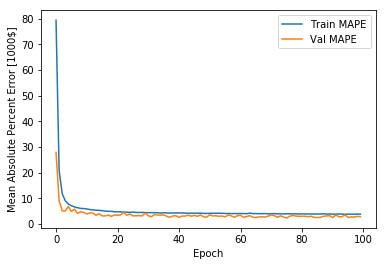

<Figure size 432x288 with 0 Axes>

In [23]:
def keras_dnn(x_train, y_train, x_test, y_test):

    '''Using normalized data to predict day ahead prices'''
    import pandas as pd
    #from sklearn.cross_validation import train_test_split
    from IPython import display
    from matplotlib import cm
    from matplotlib import gridspec
    from matplotlib import pyplot as plt
    import numpy as np
    import pandas as pd
    from sklearn import metrics
    import tensorflow as tf
    from tensorflow.python.data import Dataset
    import keras
    from keras.utils import to_categorical
    from keras import models
    from keras import layers
    import math
    import matplotlib.pyplot as plt
    #df = pd.read_csv('covtype.csv')


    hl_scaling = 4
    input_layer = np.shape(x_train)[1]
    output_layer = 1
    middle_hidden_layer = round((np.shape(x_train)[0])/(hl_scaling*(np.shape(x_train)[1]+output_layer)))

    #x_train, x_test, y_train, y_test = train_test_split(x, y , train_size = 0.7, random_state =  90)
    #'''As y variable is multi class categorical variable, hence using softmax as activation function and sparse-categorical cross entropy as loss function.'''
    model = keras.Sequential([
     keras.layers.Dense(input_layer, kernel_initializer='normal', activation=tf.nn.relu,                  
     input_shape=(x_train.shape[1],)),
     #keras.layers.Dropout(0.8, noise_shape=None, seed=None),

     keras.layers.Dense(middle_hidden_layer,  kernel_initializer='normal', activation=tf.nn.relu),
  #   keras.layers.Dropout(0.8, noise_shape=None, seed=None),
     keras.layers.Dense(round(middle_hidden_layer/2),  kernel_initializer='normal', activation=tf.nn.relu),
        
  #   keras.layers.Dense(round(middle_hidden_layer/4),  kernel_initializer='normal', activation=tf.nn.relu),

     keras.layers.Dense(output_layer, activation='linear'),


     #keras.layers.Dense(1, activation=  'softmax')
     ])
    
    model.compile(optimizer='adam',
              loss='mean_absolute_percentage_error',
              metrics=['mean_absolute_percentage_error'])
    history1 = model.fit(
     x_train, y_train,
     epochs= 100, batch_size = 100,
     validation_data = (x_test, y_test))

    return history1, model

#make plots
def plot_history(history1):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('Mean Absolute Percent Error [1000$]')
 plt.plot(history1.epoch, np.array(history1.history['mean_absolute_percentage_error']),
 label='Train MAPE')
 plt.plot(history1.epoch, np.array(history1.history['val_mean_absolute_percentage_error']),
 label = 'Val MAPE')
 plt.legend()

[history1, model] = keras_dnn(x_train_c, y_train, x_test_c, y_test)

plot_history(history1)

# Plot Back-testing prediction
predictedkieras = model.predict(x_test_c.tail(24))
plt.figure()

MAP_error5 = mean_absolute_percentage_error(predictedkieras.flatten(), y_test)


#plt.plot(ynew)
#plt.plot(y_test.reset_index(drop=True))
#plt.show()

#plt.figure()
#plt.scatter(y_test,pd.DataFrame(ynew))
#max_x = max(y_test)
#min_x = min(y_test)
#max_y = max(ynew)
#min_y = min(ynew)
#plt.xlim(min_x, max_x)
#plt.ylim(min_y, max_y)
#plt.plot([min_x, max_x], [min_x, max_x], 'k--')
#plt.show()

print(MAP_error5)

tree5_prediction = model.predict(x_pred_c.tail(24))
#plt.figure()
#plt.plot(tree5_prediction.flatten())
#plt.show()


# Deep Neural Network (Scikit Learn MLPRegressor)

In [24]:
def dnn_prediction(list_var):
    """
    Support vector regression algorithm.

    :param list_var: List with the test and train components.
    :return: The SVR model.
    """
    # Unpacking the variables
    x_train_c, y_train, x_test_c, y_test = list_var

    cv_splits = 4
    hl_scaling = 2
    input_layer = np.shape(x_train_c)[1]
    output_layer = 1
    middle_hidden_layer = round((np.shape(x_train_c)[0])/(hl_scaling*(np.shape(x_train_c)[1]+output_layer)))

    # Defining the ML ensemble methods to apply
    clf = MLPRegressor( hidden_layer_sizes=(input_layer,middle_hidden_layer,output_layer),  activation='identity', solver='adam', alpha=0.001, batch_size='auto',
    learning_rate='adaptive', learning_rate_init=0.0005, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=True, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
    early_stopping=False, validation_fraction=0.2, beta_1=0.9, beta_2=0.99, epsilon=1e-08)
    

    param_grid = {}
    

    dnn_grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, iid=True,
                            refit=True, cv=cv_splits, scoring='neg_mean_absolute_error')


    dnn_fit = dnn_grid.fit(x_train_c, y_train)
    
    dnn_grid.fit(x_train_c, y_train)

    # Printing the best parameters of the model

    # Predicting the data using the test data
    dnn_predict = dnn_fit.predict(x_test_c)

    #features_NN =     svr_grid.best_estimator_.feature_importances_

    #feature_imp_df_NN = pd.DataFrame({'Importance': features_NN},
    #                              index=x_test.columns.ravel()).sort_values('Importance', ascending=False)

    #feature_imp_plot(imp_feat)
    #print(feature_imp_df_NN)

    # Printing the scores to estimate the quality of the model.
    print('r2_score:', r2_score(y_test, dnn_predict), '\n',
          'mean_squared_error', mean_squared_error(y_test, dnn_predict), '\n',
          'mean_absolute_error', mean_absolute_error(y_test, dnn_predict), '\n',
          'mean_absolute_percentage_error', mean_absolute_percentage_error(y_test, dnn_predict), '\n')
    print('best parameters: ', dnn_fit.best_params_)

    print('\n')

    def metric_model_plot_dnn(y_test_c_f, dnn_predict_f):

        max_x = max(dnn_predict_f)
        min_x = min(dnn_predict_f)
        plt.figure()
        plt.scatter(y_test_c_f, dnn_predict_f, c="darkorange", label="data")
        plt.plot([min_x, max_x], [min_x, max_x], 'k--')
        plt.xlabel("Actual values")
        plt.ylabel("Predicted values")
        plt.title("Decision Tree")
        plt.legend()
        #plt.savefig('fig_svm.png')
        plt.show()
        return None

    #metric_model_plot_dnn(y_test, dnn_predict)
    return dnn_fit


In [25]:
# Train Model
model_dl = dnn_prediction([x_train_c, y_train, x_test_c, y_test])
# Back-testing error and Day Ahead Prediction
dnn_map = mean_absolute_percentage_error(y_test, model_dl.predict(x_test_c))
dnn_test_prediction = model_dl.predict(x_test_c)

dnn_prediction = list(model_dl.predict(x_pred_c))

Iteration 1, loss = 1630.81407689
Iteration 2, loss = 1434.99954022
Iteration 3, loss = 1169.33723577
Iteration 4, loss = 799.00245674
Iteration 5, loss = 380.76641660
Iteration 6, loss = 99.54785013
Iteration 7, loss = 17.85740279
Iteration 8, loss = 9.82428746
Iteration 9, loss = 8.49990951
Iteration 10, loss = 7.98474985
Iteration 11, loss = 7.69586879
Iteration 12, loss = 7.51133262
Iteration 13, loss = 7.39005192
Iteration 14, loss = 7.32577299
Iteration 15, loss = 7.33176745
Iteration 16, loss = 7.22319110
Iteration 17, loss = 7.18590313
Iteration 18, loss = 7.19544082
Iteration 19, loss = 7.25868476
Iteration 20, loss = 7.24802915
Iteration 21, loss = 7.21219508
Iteration 22, loss = 7.21726939
Iteration 23, loss = 7.17883645
Iteration 24, loss = 7.20759776
Iteration 25, loss = 7.17811221
Iteration 26, loss = 7.26432598
Iteration 27, loss = 7.16660529
Iteration 28, loss = 7.14430821
Iteration 29, loss = 7.12897885
Iteration 30, loss = 7.21615006
Iteration 31, loss = 7.20049557
It

# PCA-XGBoostGPU 

In [26]:

from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
predicted6, y_test6, tree6, MAP_error6 = prediction_xgboost_gpu_optimise(X_train, y_train, X_test, y_test)

tree6_prediction = list(tree6.predict(X_pred))

    Model training
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   18.8s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   24.4s finished


{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.03, 'gpu_id': 0, 'learning_rate': 0.1, 'max_bin': 256, 'n_estimators': 400, 'predictor': 'gpu_predictor', 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
                                                    Importance
REE_DEMAND_ES_1fut                                    0.108225
(VALUE, ENTSOE: Day Ahead Prices - Espanha (Esp...    0.090909
Wind_ES_1fut                                          0.083694
PRECO_FR_1fut                                         0.079365
HORA                                                  0.059163
4                                                     0.056277
3                                                     0.050505
PRECO_ES                                              0.047619
(VALUE, Precos de Energia Mercado Diario Nordpo...    0.034632
Wind_ES                                               0.031746
(VALUE, Taxa de Cambio EUR / MOP - Re

In [27]:
model_1_map = MAP_error1
model_2_map = MAP_error2
model_3_map = MAP_error3
model_4_map = MAP_error4
model_5_map = dnn_map
model_6_map = MAP_error5
model_0_map = MAP_error6


models_list = [model_1_map, model_2_map, model_3_map, model_4_map, model_5_map, model_6_map, model_0_map]
minIndex = models_list.index(min(models_list))
minIndex

models_output = np.array([list(tree1_prediction), 
                                list(tree2_prediction), 
                                list(tree3_prediction), 
                                list(ensemble_prediction),
                                list(dnn_prediction),
                                list(tree5_prediction),
                                list(tree6_prediction)

                                 ])

model_names = np.array(['1.PCA-XGBgpu-opt', '2.PCA-XGB', '3.XGBgpu-opt', 'RF-Ensemble', 'TF-MLP', 'KR-DNN', '4.PCA-XGBgpu-opt'])


import csv 
import datetime
now = datetime.datetime.now()

HOURS = pd.DataFrame(list(range(1,25)), columns = ['Hour'])

csvfile_top = pd.DataFrame(list(models_output[minIndex,:]), columns = ['Best_test'])

csvfile_1 = pd.DataFrame(list(tree1_prediction), columns = ['PCA-XGBgpu-opt'])

csvfile_2 = pd.DataFrame(list(tree2_prediction), columns = ['PCA-XGB'])

csvfile_3 = pd.DataFrame(list(tree3_prediction), columns = ['XGBgpu-opt'])

csvfile_4= pd.DataFrame(list(ensemble_prediction), columns = ['RF-Ensemble'])

csvfile_5 = pd.DataFrame(list(dnn_prediction), columns = ['TF-MLP'])

csvfile_6 = pd.DataFrame(list(tree5_prediction.flatten()), columns = ['KR-DNN'])

csvfile_0 = pd.DataFrame(list(tree6_prediction), columns = ['PCA-XGBgpu-opt'])

cvfileall = pd.concat([HOURS, csvfile_top, csvfile_0, csvfile_1, csvfile_2, csvfile_3, csvfile_4, csvfile_5,csvfile_6], axis = 1)

test_date = pred_date_END+timedelta(1)
test_date = test_date.strftime('%Y%m%d')

prediction_date = pred_date_END+timedelta(2)
prediction_date = prediction_date.strftime('%Y%m%d')

cvfileall.to_excel('C:/Users/e351722/OneDrive - EDP/REN_prediction/results/daily_prediction_'+prediction_date+'_'+str(now.hour)+'h'+'.xlsx', sheet_name='sheet1', index=False)

In [28]:
model_test_preds = np.array([list(predicted1),
                             list(predicted2),
                             list(predicted3),
                             list(predicted_ensemble_test),
                             list(dnn_test_prediction), 
                             list(predictedkieras),
                             list(predicted6)
])

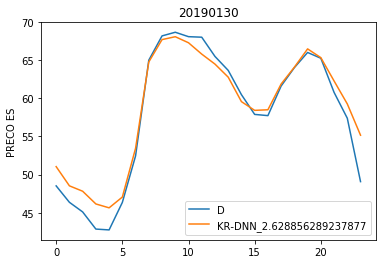

In [29]:
plt.plot(y_test, label= 'D')
plt.plot(model_test_preds[minIndex], label= model_names[minIndex]+'_'+str(models_list[minIndex]))

#plt.plot(predictedkieras, label= model_names[5]+'_'+str(models_list[5]))

plt.legend()

plt.title(str(test_date))

plt.ylabel('PRECO ES')

plt.savefig('C:/Users/e351722/OneDrive - EDP/REN_prediction/validation/daily_prediction_cv_'+prediction_date+'_'+str(now.hour)+'h'+ '.png')  # save the figure to file
